# EDA Clusters Obesity

La variable objetivo no existe dentro del conjunto de datos. Tampoco existe una fórmula que me permita calcularla.

Una solución es utilizar un algoritmo de clasificación no supervisada para identificar los grupos de datos similares y así poder etiquetarlos más fácilmente.

Consideraré 2 algoritmos:

1. K-Means: Utilizando las variables originales que no han sido calculadas: age_range, gender, height, weight, waist_circum_preferred y hip_circum
2. K_Modes: Con las varaibles categóricas siguientes que han sido calculadas y que implicitamente toman en cuenta las otras variables: obesity_bmi, obesity_cc, obesity_rcc, 'obesity_ict y risk_factors

#### Procedimiento:

1. Buscar el número óptimo de clusters utilizando KMeans y KModes
2. Una vez determinado el número óptimo de clusters, estudiar cuál de los 2 algoritmos genera los clusters más sencillos de etiquetar
3. Etiquetar los registros del dataframe basándome en los clusters creados por el algoritmo seleccionado en el punto 2
4. Estudio de los datos ya etiquetados
5. Guardar el DF en un archivo parquet para el resto del estudio


In [1]:
# Librerías

from pathlib import Path

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt # importar altair con el alias alt

# Transformar columnas
from sklearn.preprocessing import OneHotEncoder, Binarizer, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer

# Clasificación no supervisada
from sklearn.cluster import KMeans
from kmodes.kmodes import KModes

# Métricas para evaluar modelos
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn import metrics

# Armando pipelines
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion, Pipeline

# Funciones propias
import data_common_functions as dcf
import char_common_functions as ccf

In [2]:
def generate_df_kmeans(df):
    
    df_to_transform = df.loc[:, ['age_range',
                                 'gender_bin',
                                 'height',
                                 'weight',
                                 'waist_circum_preferred',
                                 'hip_circum',
                                 'risk_factors'] ]
    
    
    columns_to_encode = ['age_range']
    columns_to_scale = ['height', 'weight', 'waist_circum_preferred', 'hip_circum']
    # Passthrough columns
    columns_to_pass = ['risk_factors', 'gender_bin']
    
    df_kmeans = dcf.transform_df(df_to_transform, columns_to_encode, columns_to_scale, columns_to_pass)

    return df_kmeans

In [3]:
def generate_df_kmodes(df):
    
    df_to_transform = df.loc[:, [ 'age_range', 
                            'obesity_bmi',
                            'obesity_cc',
                            'obesity_rcc',
                            'obesity_ict',
                            'risk_factors'
                                ] ]
    
    columns_to_encode = ['age_range']
    columns_to_scale = []
    # Passthrough columns
    columns_to_pass = [ 'obesity_bmi',
                        'obesity_cc',
                        'obesity_rcc',
                        'obesity_ict',
                        'risk_factors'
                      ]
    
    df_kmodes = dcf.transform_df(df_to_transform, columns_to_encode, columns_to_scale, columns_to_pass)
    
    return df_kmodes

In [4]:
def test_kmeans(df, n_clusters_list):
    
    trained_models = []
    results = []
    
    df_kmeans = generate_df_kmeans(df)
    
    print('*****************************')
    print('TESTS KMeans')
    print('*****************************')
    
    print(n_clusters_list)
    
    for n_clusters in n_clusters_list:
        model = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
        model.fit(df_kmeans)
        print("n_clusters", n_clusters, model.inertia_)
        trained_models.append(model)

        # Métricas del modelo
        result = {
            'model': 'KMeans',
            'n_clusters': n_clusters,
            'inertia': model.inertia_,
            'silhouette_score': silhouette_score(df_kmeans, model.labels_),
            'calinski_harabasz_score': calinski_harabasz_score(df_kmeans, model.labels_),
            'davies_bouldin_score': davies_bouldin_score(df_kmeans, model.labels_),
            }
      
        results.append(result)
        
    inertias_costs = [model.inertia_ for model in trained_models]

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(n_clusters_list, inertias_costs , marker='o')
    ax.set_xlabel('Número de clusters')
    ax.set_ylabel('Inercia o Costo')
    ax.set_title(f'Regla del codo Kmeans')
    
    return pd.DataFrame(results)
 

In [5]:
def test_kmodes(df, n_clusters_list):
   
    trained_models = []
    results = []
    
    df_kmodes = generate_df_kmeans(df)
    
    print('*****************************')
    print('TEST KModes')
    print('*****************************')
    
    print(n_clusters_list)
    
    for n_clusters in n_clusters_list:

        model = KModes(n_clusters=n_clusters, init='Huang', n_init=10, random_state=42)
        model.fit(df_kmodes)
        print("n_clusters", n_clusters, model.cost_)
        trained_models.append(model)

        # Métricas del modelo
        result = {
            'model': 'KModes',
            'n_clusters': n_clusters,
            'cost': model.cost_,
            'silhouette_score': silhouette_score(df_kmodes, model.labels_),
            'calinski_harabasz_score': calinski_harabasz_score(df_kmodes, model.labels_),
            'davies_bouldin_score': davies_bouldin_score(df_kmodes, model.labels_)
        }
            
        results.append(result)
        
    costs = [model.cost_ for model in trained_models]

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(n_clusters_list, costs , marker='o')
    ax.set_xlabel('Número de clusters')
    ax.set_ylabel('Costo')
    ax.set_title(f'Regla del codo KModes')
      
    return pd.DataFrame(results)
 

In [6]:
def char_cluster(df):
    
    title = 'Cantidad de individuos por etiqueta'
    
    tooltip=[alt.Tooltip('label:N'),
             alt.Tooltip('count(*):Q', title='Cantidad individuos')]
    
    bars = alt.Chart(df).mark_bar().encode(
        x='count(*):Q',
        y='label:N',
        tooltip=tooltip,
        color=alt.Color('label:N') 
    ).properties(
        title=title,
        width=500, 
        height=250
    )

    return bars

def char_cluster_risk_factors(df, cluster):
    
    query = f'cluster=={cluster}'
    
    df = df.query(query)[['cluster', 'risk_factors']]
    
    sns.countplot(x='cluster', hue='risk_factors', data=df)
    return plt.show()


def char_cluster_age(df, cluster):
    
    query = f'cluster=={cluster}'
    
    df = df.query(query)[['cluster', 'age_range']]
    
    sns.countplot(x='cluster', hue='age_range', data=df)
    return plt.show()

def char_cluster_genre(df, cluster):
    
    query = f'cluster=={cluster}'
    
    df = df.query(query)[['cluster', 'gender']]
    
    sns.countplot(x='cluster', hue='gender', data=df)
    return plt.show()


def define_label(bmi, cc, rcc, ict):
    return bmi + '-' + cc + '-' + rcc + '-' + ict

def eda_cluster(df, cluster):   
    
    print(f'EDA cluster {cluster}')
    print('**************************')
    
    query = f'cluster=={cluster}'
    df_table = df.query(query)[[#'gender', 
                                'age_range',
                                'obesity_bmi_txt', 'obesity_cc_txt',  
                                'obesity_rcc_txt', 'obesity_ict_txt', 
                                'risk_factors', 'cluster']]
    df_eda_cluster = pd.pivot_table(df_table, 
                                index=[#'gender', 
                                       'age_range',
                                       'obesity_bmi_txt', 'obesity_cc_txt',  
                                       'obesity_rcc_txt', 'obesity_ict_txt', 'risk_factors'],
                                    aggfunc='count')
    
    print(df_eda_cluster)   
    
    df_eda_cluster.reset_index(inplace=True)
    
    df_eda_cluster.rename(columns={'obesity_bmi_txt': 'bmi',
                                  'obesity_cc_txt': 'cc',
                                  'obesity_rcc_txt': 'rcc',
                                  'obesity_ict_txt': 'ict'
                                 }, inplace=True)

    df_eda_cluster['label'] = df_eda_cluster.apply(lambda  row: define_label(row['bmi'], row['cc'],
                                                                      row['rcc'], row['ict']), axis=1)
    
    char_cluster_risk_factors(df, cluster)
    char_cluster_genre(df, cluster)
    char_cluster_age(df, cluster)
    
    return char_cluster(df_eda_cluster)

In [7]:
def generate_kmeans_clusters(df, n_clusters, random_state):
    
    df_kmeans = generate_df_kmeans(df)
    
    k_means = KMeans(n_clusters=n_clusters, random_state=random_state, n_init='auto')
    cluster_labels = k_means.fit_predict(df_kmeans)

    # Agrega los resultados de la agrupación al dataframe original
    df['cluster_kmeans'] = cluster_labels

    # Evalúa el rendimiento del clustering utilizando el coeficiente de silueta
    silhouette_avg = silhouette_score(df_kmeans, cluster_labels)
    print("Coeficiente de Silueta:", silhouette_avg)

    # Muestra la distribución de los datos en cada cluster
    cluster_counts = df['cluster_kmeans'].value_counts()
    print("Distribución de datos en cada cluster:\n", cluster_counts)
    
    df_eda_kmeans = df.copy()
    
    df_eda_kmeans.rename(columns={'cluster_kmeans': 'cluster'}, inplace=True)

    # EDA de cada cluster para identificar patrones
    for i in range(n_clusters):
        eda_cluster(df_eda_kmeans, i)
    

In [8]:
def generate_kmodes_clusters(df, n_clusters, n_init, random_state):    
    
    df_kmodes = generate_df_kmodes(df)
    
    k_modes = KModes(n_clusters=n_clusters, init='Huang', n_init=n_init, random_state=random_state)
    cluster_labels = k_modes.fit_predict(df_kmodes)

    # Agrega los resultados de la agrupación al dataframe original
    df['cluster'] = cluster_labels

    # Evalúa el rendimiento del clustering utilizando el coeficiente de silueta
    silhouette_avg = silhouette_score(df_kmodes, cluster_labels)
    print("Coeficiente de Silueta:", silhouette_avg)

    # Muestra la distribución de los datos en cada cluster
    cluster_counts = df['cluster'].value_counts()
    print("Distribución de datos en cada cluster:\n", cluster_counts)

    # EDA de cada cluster para identificar patrones
    for i in range(n_clusters):
        eda_cluster(df, i)
    

## Main

In [9]:
# Leemos el archivo
CURRENT_DIR = Path.cwd()

BASE_DIR = Path(CURRENT_DIR).parent

df_obesity = pd.read_parquet(f"{BASE_DIR}/data/out/obesity.parquet", engine='fastparquet')

df_obesity

age age_range  gender    height   weight  waist_circum_preferred  \
1     47.0     46-55    male  187.1980  156.630                138.5062   
2     50.0     46-55    male  180.5940   98.064                 98.3996   
3     28.0     26-35    male  182.7022   89.211                 97.0026   
4     52.0     46-55    male  185.9026  113.273                105.9942   
5     50.0     46-55    male  183.1086  108.279                104.0892   
...    ...       ...     ...       ...      ...                     ...   
4460  35.0     26-35  female  152.8064   49.259                 61.5950   
4461  40.0     36-45  female  168.6052   67.646                 73.8124   
4462  23.0     17-25  female  168.5036   73.775                 78.0034   
4463  24.0     17-25    male  170.5102   65.149                 75.7936   
4464  22.0     17-25  female  170.4086   61.290                 68.8086   

      hip_circum  gender_bin        bmi       rcc       ict  obesity_bmi  \
1       142.1892           1  44.696399  0.974098  0.739891            3   
2       109.9058           1  30.067891  0.895309  0.544866            3   
3       107.0102           1  26.725809  0.906480  0.530933            2   
4       111.0996           1  32.775964  0.954047  0.570160            3   
5       112.3950           1  32.294365  0.926102  0.568456            3   
...          ...         ...        ...       ...       ...          ...   
4460     93.0910           0  21.096116  0.661664  0.403092            1   
4461    100.4062           0  23.795794  0.735138  0.437782            1   
4462    109.7026           0  25.983093  0.711044  0.462918            2   
4463     97.7900           1  22.408203  0.775065  0.444511            1   
4464    101.6000           0  21.106033  0.677250  0.403786            1   

     obesity_bmi_txt  obesity_cc obesity_cc_txt  obesity_rcc obesity_rcc_txt  \
1         3-Obesidad           1         1-Alto            1         1-Medio   
2         3-Obesidad           1         1-Alto            0          0-Bajo   
3        2-Sobrepeso           1         1-Alto            0          0-Bajo   
4         3-Obesidad           1         1-Alto            1         1-Medio   
5         3-Obesidad           1         1-Alto            0          0-Bajo   
...              ...         ...            ...          ...             ...   
4460        1-Normal           0         0-Bajo            0          0-Bajo   
4461        1-Normal           0         0-Bajo            0          0-Bajo   
4462     2-Sobrepeso           0         0-Bajo            0          0-Bajo   
4463        1-Normal           0         0-Bajo            0          0-Bajo   
4464        1-Normal           0         0-Bajo            0          0-Bajo   

      obesity_ict obesity_ict_txt  risk_factors  
1               3      3-Obesidad             4  
2               2     2-Sobrepeso             3  
3               2     2-Sobrepeso             3  
4               2     2-Sobrepeso             4  
5               2     2-Sobrepeso             3  
...           ...             ...           ...  
4460            0       0-Delgado             0  
4461            1        1-Normal             0  
4462            1        1-Normal             1  
4463            1        1-Normal             0  
4464            0       0-Delgado             0  

[4430 rows x 20 columns]

## Clasificación no supervisada

#### Probar KMeans: 2 a 7 clusters

1. Con los datos brutos
2. Con los datos escalados
3. Con los datos categóricos: Indicadores de obesidad
4. Con todos los datos
5. Descartando edad y género

Evaluar para cada caso 

#### Probar KMode: 2 a 7 clusters

1. Con los datos categóricos: Indicadores de obesidad
2. Con todos los datos
3. Descartando edad y género


Para evaluar todos los casos, usaremos:

- KMeans: Inercia, Coheficiente de Silhouette, Índice Calinski Harabasz, Índice Ddavies Bouldin
- KModes: Costos
- Regla del codo


### Test KMeans

[[ 1.5655069   4.42115649  4.02709295  3.76488022  4.          1.        ]
 [ 0.9296933   1.24116886  1.0252678   0.62226097  3.          1.        ]
 [ 1.13266456  0.76047306  0.92070771  0.34038954  3.          1.        ]
 ...
 [-0.23433468 -0.07766321 -0.50130953  0.60248052  1.          0.        ]
 [-0.04114517 -0.54603348 -0.66670458 -0.55714846  0.          1.        ]
 [-0.05092691 -0.75556755 -1.18950503 -0.18626499  0.          0.        ]]
*****************************
TESTS KMeans
*****************************
[2, 3, 4, 5, 6, 8, 10, 12]
n_clusters 2 15003.853293469372
n_clusters 3 11742.384606514857
n_clusters 4 9050.594079742868
n_clusters 5 8139.317329157744
n_clusters 6 7054.825610411064
n_clusters 8 5797.430137427116
n_clusters 10 5059.452918711494
n_clusters 12 4441.713984202424


model  n_clusters       inertia  silhouette_score  \
0  KMeans           2  15003.853293          0.447449   
1  KMeans           3  11742.384607          0.331082   
2  KMeans           4   9050.594080          0.333275   
3  KMeans           5   8139.317329          0.289243   
4  KMeans           6   7054.825610          0.291037   
5  KMeans           8   5797.430137          0.279515   
6  KMeans          10   5059.452919          0.280528   
7  KMeans          12   4441.713984          0.290429   

   calinski_harabasz_score  davies_bouldin_score  
0              4168.781623              0.935931  
1              3277.554899              1.061256  
2              3273.035605              1.098720  
3              2852.903304              1.158326  
4              2768.546943              1.152033  
5              2542.358443              1.136929  
6              2336.419352              1.152067  
7              2232.350038              1.088390

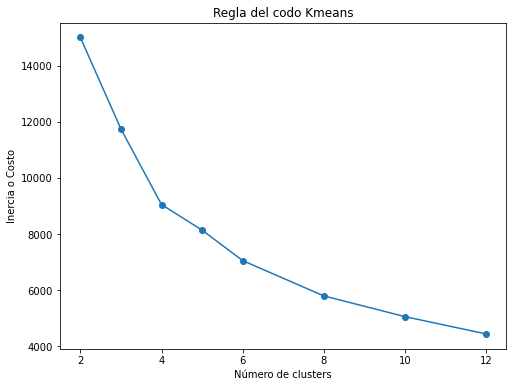

In [10]:
n_clusters_list = [2, 3, 4, 5, 6, 8, 10, 12]

result = test_kmeans(df_obesity, n_clusters_list)

result

### Test KModes

[[ 1.5655069   4.42115649  4.02709295  3.76488022  4.          1.        ]
 [ 0.9296933   1.24116886  1.0252678   0.62226097  3.          1.        ]
 [ 1.13266456  0.76047306  0.92070771  0.34038954  3.          1.        ]
 ...
 [-0.23433468 -0.07766321 -0.50130953  0.60248052  1.          0.        ]
 [-0.04114517 -0.54603348 -0.66670458 -0.55714846  0.          1.        ]
 [-0.05092691 -0.75556755 -1.18950503 -0.18626499  0.          0.        ]]
*****************************
TEST KModes
*****************************
[2, 3, 4, 5, 6, 8, 10]
n_clusters 2 19974.0
n_clusters 3 19496.0
n_clusters 4 19043.0
n_clusters 5 18769.0
n_clusters 6 18315.0
n_clusters 8 18019.0
n_clusters 10 17858.0


model  n_clusters     cost  silhouette_score  calinski_harabasz_score  \
0  KModes           2  19974.0          0.186943               749.999201   
1  KModes           3  19496.0          0.196223              1375.682152   
2  KModes           4  19043.0          0.102579               893.336798   
3  KModes           5  18769.0          0.202899              1569.066864   
4  KModes           6  18315.0          0.143005              1020.578556   
5  KModes           8  18019.0          0.077747               801.245518   
6  KModes          10  17858.0          0.126753              1013.237461   

   davies_bouldin_score  
0              2.171623  
1              1.474662  
2              5.096914  
3              1.563791  
4              3.228731  
5              4.912059  
6              2.012856

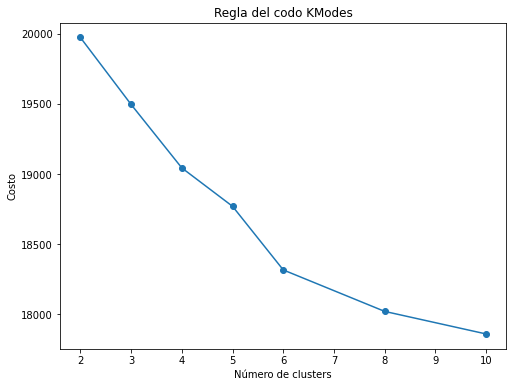

In [11]:
n_clusters_list = [2, 3, 4, 5, 6, 8, 10]

result = test_kmodes(df_obesity, n_clusters_list)

result

### Estudio clusters KMeans

[[ 1.5655069   4.42115649  4.02709295  3.76488022  4.          1.        ]
 [ 0.9296933   1.24116886  1.0252678   0.62226097  3.          1.        ]
 [ 1.13266456  0.76047306  0.92070771  0.34038954  3.          1.        ]
 ...
 [-0.23433468 -0.07766321 -0.50130953  0.60248052  1.          0.        ]
 [-0.04114517 -0.54603348 -0.66670458 -0.55714846  0.          1.        ]
 [-0.05092691 -0.75556755 -1.18950503 -0.18626499  0.          0.        ]]
Coeficiente de Silueta: 0.29103739718495997
Distribución de datos en cada cluster:
 0    1154
2    1099
4     759
1     667
3     618
5     133
Name: cluster_kmeans, dtype: int64
EDA cluster 0
**************************
                                                                                       cluster
age_range obesity_bmi_txt obesity_cc_txt obesity_rcc_txt obesity_ict_txt risk_factors         
17-25     0-Bajo Peso     0-Bajo         0-Bajo          0-Delgado       0                   9
                                       

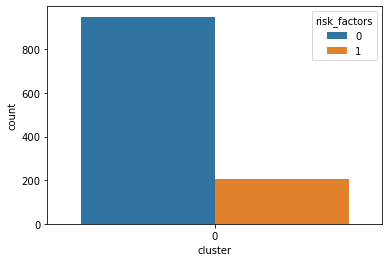

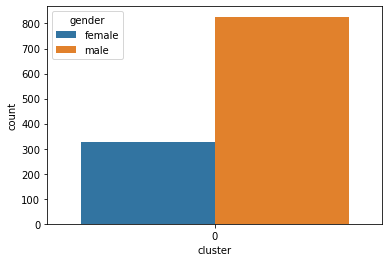

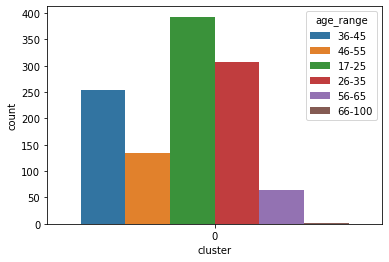

EDA cluster 1
**************************
                                                                                       cluster
age_range obesity_bmi_txt obesity_cc_txt obesity_rcc_txt obesity_ict_txt risk_factors         
17-25     2-Sobrepeso     1-Alto         0-Bajo          2-Sobrepeso     3                  12
                                         1-Medio         2-Sobrepeso     4                   4
                                                         3-Obesidad      4                   1
                                         2-Alto          2-Sobrepeso     4                   1
                                                         3-Obesidad      4                   1
          3-Obesidad      0-Bajo         0-Bajo          2-Sobrepeso     2                   1
                          1-Alto         0-Bajo          2-Sobrepeso     3                  14
                                                         3-Obesidad      3                   3
         

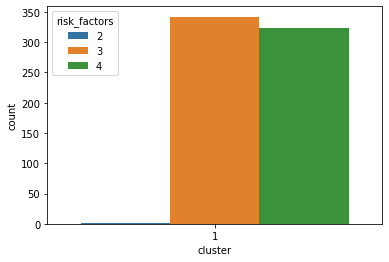

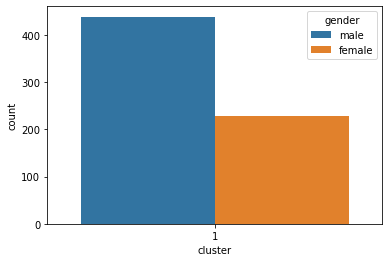

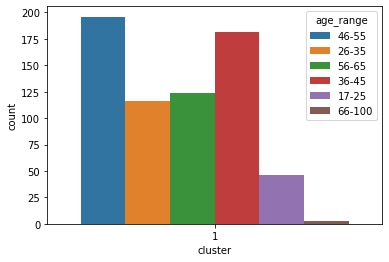

EDA cluster 2
**************************
                                                                                       cluster
age_range obesity_bmi_txt obesity_cc_txt obesity_rcc_txt obesity_ict_txt risk_factors         
17-25     0-Bajo Peso     0-Bajo         0-Bajo          0-Delgado       0                  14
                                                         1-Normal        0                  11
                                         1-Medio         0-Delgado       1                   1
                                                         1-Normal        1                   4
                                         2-Alto          1-Normal        1                   1
                                                         2-Sobrepeso     2                   1
          1-Normal        0-Bajo         0-Bajo          0-Delgado       0                  39
                                                         1-Normal        0                 208
         

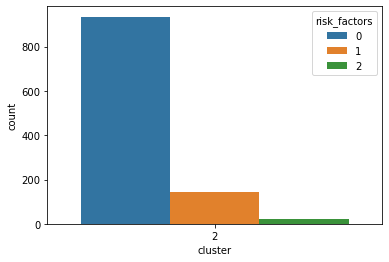

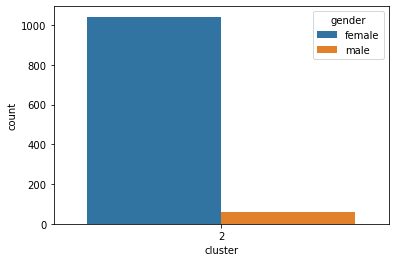

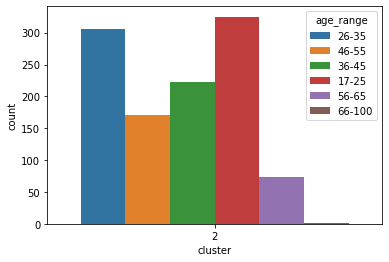

EDA cluster 3
**************************
                                                                                       cluster
age_range obesity_bmi_txt obesity_cc_txt obesity_rcc_txt obesity_ict_txt risk_factors         
17-25     1-Normal        0-Bajo         0-Bajo          1-Normal        0                  38
                          1-Alto         0-Bajo          1-Normal        1                  12
                                                         2-Sobrepeso     2                   1
                                         2-Alto          1-Normal        2                   1
          2-Sobrepeso     0-Bajo         0-Bajo          1-Normal        1                  39
                                                         2-Sobrepeso     2                   8
                          1-Alto         0-Bajo          1-Normal        2                   8
          3-Obesidad      0-Bajo         0-Bajo          1-Normal        1                   2
         

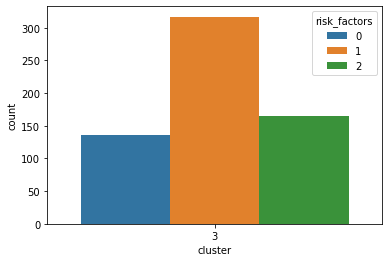

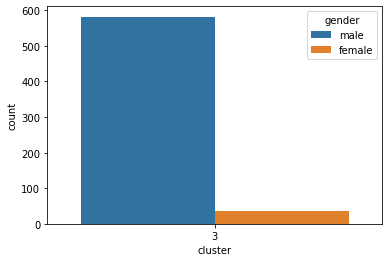

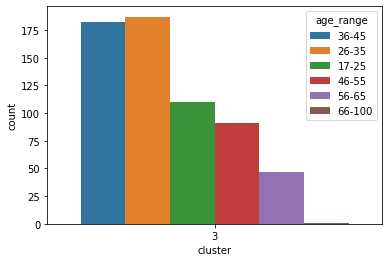

EDA cluster 4
**************************
                                                                                       cluster
age_range obesity_bmi_txt obesity_cc_txt obesity_rcc_txt obesity_ict_txt risk_factors         
17-25     1-Normal        0-Bajo         1-Medio         2-Sobrepeso     2                   5
                          1-Alto         0-Bajo          2-Sobrepeso     2                  11
                                         1-Medio         1-Normal        2                   3
                                                         2-Sobrepeso     3                  24
                                         2-Alto          1-Normal        2                   1
...                                                                                        ...
56-65     3-Obesidad      1-Alto         1-Medio         2-Sobrepeso     4                   2
                                                         3-Obesidad      4                   4
         

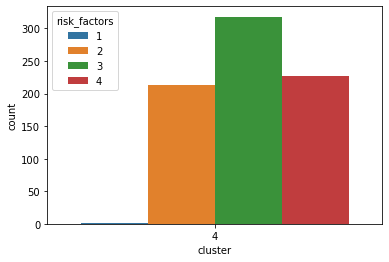

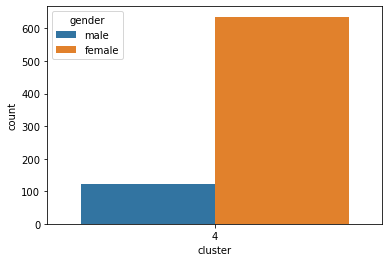

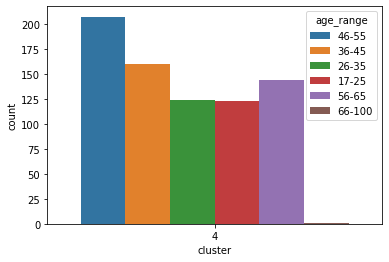

EDA cluster 5
**************************
                                                                                       cluster
age_range obesity_bmi_txt obesity_cc_txt obesity_rcc_txt obesity_ict_txt risk_factors         
17-25     3-Obesidad      1-Alto         0-Bajo          3-Obesidad      3                   3
                                         2-Alto          3-Obesidad      4                   1
26-35     3-Obesidad      1-Alto         0-Bajo          2-Sobrepeso     3                   2
                                                         3-Obesidad      3                   9
                                         1-Medio         3-Obesidad      4                   9
                                         2-Alto          3-Obesidad      4                   8
36-45     3-Obesidad      1-Alto         0-Bajo          2-Sobrepeso     3                   3
                                                         3-Obesidad      3                  14
         

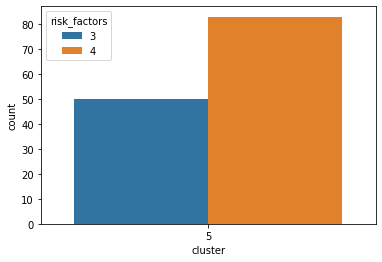

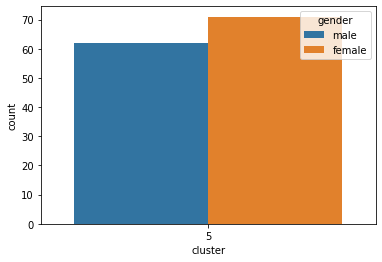

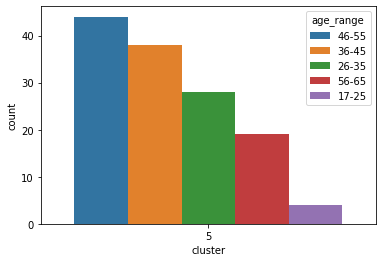

In [12]:
n_clusters = 6
random_state = 42

generate_kmeans_clusters(df_obesity, n_clusters, random_state)

### Estudio clusters KModes

[[3. 1. 1. 3. 4.]
 [3. 1. 0. 2. 3.]
 [2. 1. 0. 2. 3.]
 ...
 [2. 0. 0. 1. 1.]
 [1. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]]
Coeficiente de Silueta: 0.6099999551483146
Distribución de datos en cada cluster:
 5    1687
2     899
4     625
1     596
0     416
3     207
Name: cluster, dtype: int64
EDA cluster 0
**************************
                                                                                       cluster
age_range obesity_bmi_txt obesity_cc_txt obesity_rcc_txt obesity_ict_txt risk_factors         
17-25     0-Bajo Peso     0-Bajo         0-Bajo          0-Delgado       0                  23
                                         1-Medio         0-Delgado       1                   1
          1-Normal        0-Bajo         0-Bajo          0-Delgado       0                  74
                                                         2-Sobrepeso     1                  13
                                         1-Medio         2-Sobrepeso     2                   8
26-35    

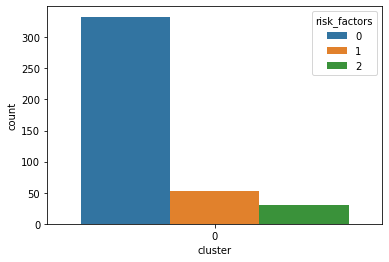

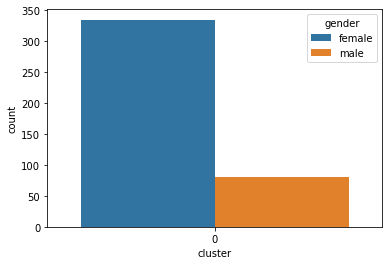

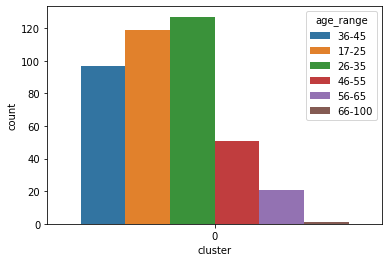

EDA cluster 1
**************************
                                                                                       cluster
age_range obesity_bmi_txt obesity_cc_txt obesity_rcc_txt obesity_ict_txt risk_factors         
17-25     1-Normal        1-Alto         1-Medio         1-Normal        2                   3
          2-Sobrepeso     1-Alto         1-Medio         2-Sobrepeso     4                  12
                                                         3-Obesidad      4                   2
                                         2-Alto          3-Obesidad      4                   2
          3-Obesidad      1-Alto         1-Medio         2-Sobrepeso     4                   2
                                                         3-Obesidad      4                   6
                                         2-Alto          3-Obesidad      4                   5
26-35     1-Normal        1-Alto         1-Medio         1-Normal        2                   2
         

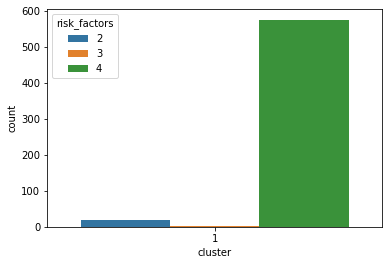

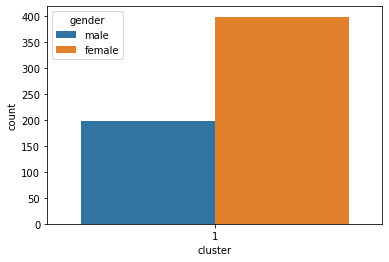

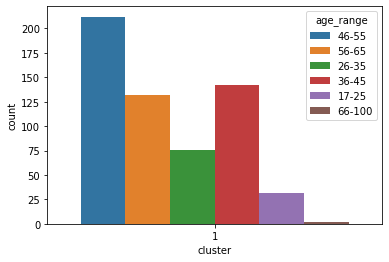

EDA cluster 2
**************************
                                                                                       cluster
age_range obesity_bmi_txt obesity_cc_txt obesity_rcc_txt obesity_ict_txt risk_factors         
17-25     0-Bajo Peso     0-Bajo         1-Medio         1-Normal        1                   5
                                         2-Alto          1-Normal        1                   1
          1-Normal        0-Bajo         1-Medio         1-Normal        1                  22
                                         2-Alto          1-Normal        1                   2
                          1-Alto         0-Bajo          1-Normal        1                  22
          2-Sobrepeso     0-Bajo         0-Bajo          0-Delgado       1                   1
                                                         1-Normal        1                  78
                                                         2-Sobrepeso     2                  19
         

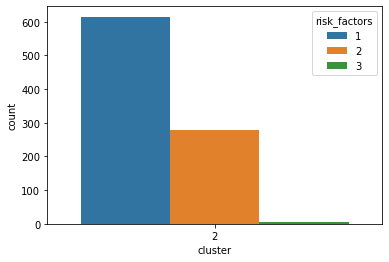

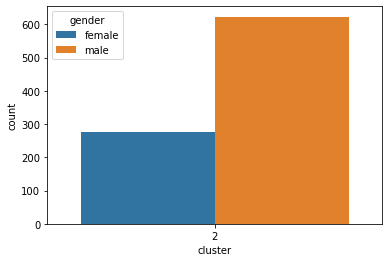

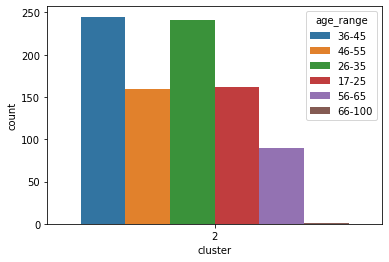

EDA cluster 3
**************************
                                                                                       cluster
age_range obesity_bmi_txt obesity_cc_txt obesity_rcc_txt obesity_ict_txt risk_factors         
17-25     0-Bajo Peso     0-Bajo         2-Alto          2-Sobrepeso     2                   1
          1-Normal        0-Bajo         2-Alto          2-Sobrepeso     2                   3
                          1-Alto         0-Bajo          2-Sobrepeso     2                  12
                                         1-Medio         2-Sobrepeso     3                  24
                                         2-Alto          1-Normal        2                   2
                                                         2-Sobrepeso     3                  13
                                                         3-Obesidad      3                   1
          2-Sobrepeso     1-Alto         2-Alto          2-Sobrepeso     4                   4
26-35    

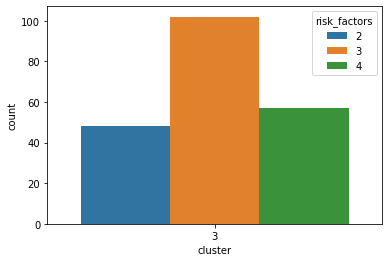

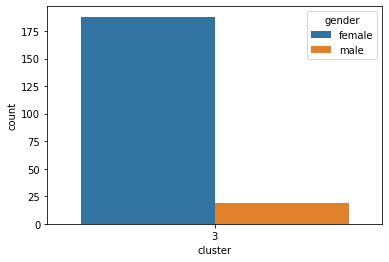

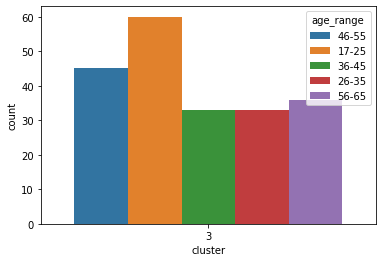

EDA cluster 4
**************************
                                                                                       cluster
age_range obesity_bmi_txt obesity_cc_txt obesity_rcc_txt obesity_ict_txt risk_factors         
17-25     2-Sobrepeso     1-Alto         0-Bajo          2-Sobrepeso     3                  36
          3-Obesidad      0-Bajo         0-Bajo          2-Sobrepeso     2                   4
                          1-Alto         0-Bajo          2-Sobrepeso     3                  21
                                                         3-Obesidad      3                   9
26-35     2-Sobrepeso     1-Alto         0-Bajo          2-Sobrepeso     3                  54
          3-Obesidad      0-Bajo         0-Bajo          2-Sobrepeso     2                   8
                          1-Alto         0-Bajo          1-Normal        2                   1
                                                         2-Sobrepeso     3                  65
         

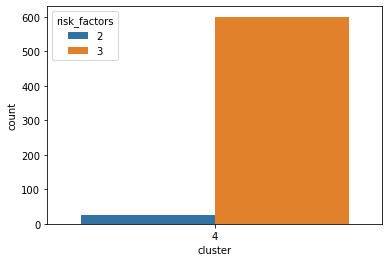

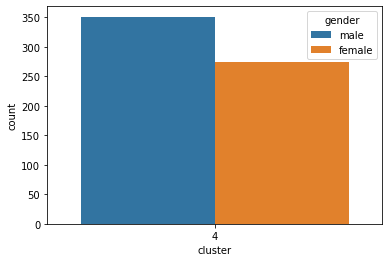

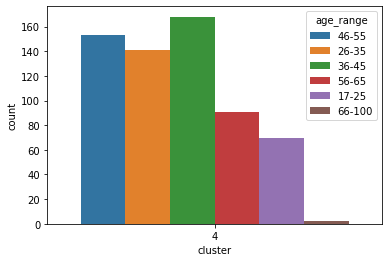

EDA cluster 5
**************************
                                                                                       cluster
age_range obesity_bmi_txt obesity_cc_txt obesity_rcc_txt obesity_ict_txt risk_factors         
17-25     0-Bajo Peso     0-Bajo         0-Bajo          1-Normal        0                  17
          1-Normal        0-Bajo         0-Bajo          1-Normal        0                 541
26-35     0-Bajo Peso     0-Bajo         0-Bajo          1-Normal        0                   4
          1-Normal        0-Bajo         0-Bajo          1-Normal        0                 446
36-45     0-Bajo Peso     0-Bajo         0-Bajo          1-Normal        0                   4
          1-Normal        0-Bajo         0-Bajo          1-Normal        0                 349
46-55     1-Normal        0-Bajo         0-Bajo          1-Normal        0                 221
56-65     0-Bajo Peso     0-Bajo         0-Bajo          1-Normal        0                   3
         

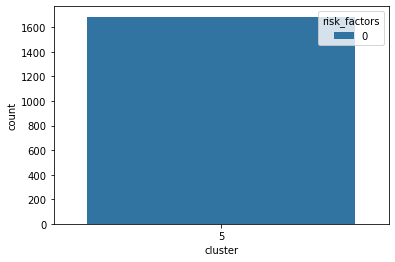

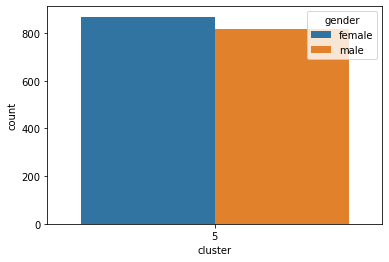

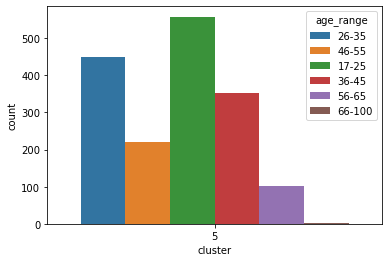

In [13]:
n_clusters = 6
n_init = 10
random_state = 20

generate_kmodes_clusters(df_obesity, n_clusters, n_init, random_state)

### Conclusiones

En vista de que el algoritmo sólo lo voy a usar para ayudarme a etiquetar los registros, busco simplemente cuál en la mejor clasificación: menor número de clusters, grupos más homogéneos.

En este caso, escogeré **KModes** para definir las etiquetas.

Estudiaré cluster por cluster para definir las etiquetas de cada uno.

### Etiquetado basado en KModes

### Cluster 0

In [14]:
def calc_obesity_kmodes_0(age, bmi, cc, rcc, ict, risk):
    
    if risk<=1: return 0
    
    if risk==2: return 1  
        
        

EDA cluster 0
**************************
                                                                                       cluster
age_range obesity_bmi_txt obesity_cc_txt obesity_rcc_txt obesity_ict_txt risk_factors         
17-25     0-Bajo Peso     0-Bajo         0-Bajo          0-Delgado       0                  23
                                         1-Medio         0-Delgado       1                   1
          1-Normal        0-Bajo         0-Bajo          0-Delgado       0                  74
                                                         2-Sobrepeso     1                  13
                                         1-Medio         2-Sobrepeso     2                   8
26-35     0-Bajo Peso     0-Bajo         0-Bajo          0-Delgado       0                  14
          1-Normal        0-Bajo         0-Bajo          0-Delgado       0                  99
                                                         2-Sobrepeso     1                   7
         

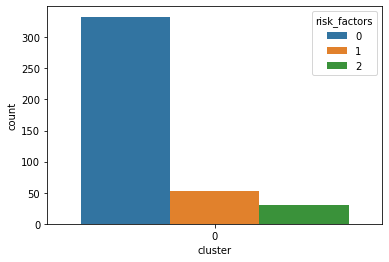

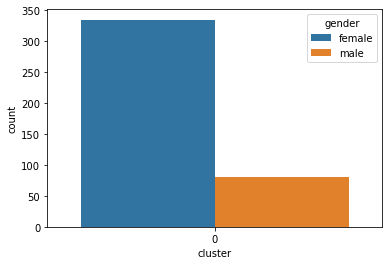

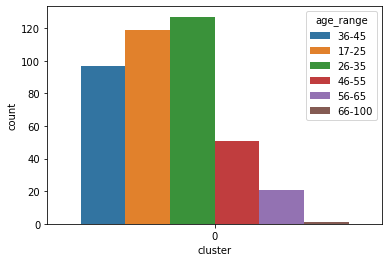

alt.Chart(...)

In [15]:
eda_cluster(df_obesity, 0)

### Cluster 1

In [16]:
def calc_obesity_kmodes_1(age, bmi, cc, rcc, ict, risk):
       
    if risk>=3: return 2 
    
    if risk==2: return 1
        
        
   

EDA cluster 1
**************************
                                                                                       cluster
age_range obesity_bmi_txt obesity_cc_txt obesity_rcc_txt obesity_ict_txt risk_factors         
17-25     1-Normal        1-Alto         1-Medio         1-Normal        2                   3
          2-Sobrepeso     1-Alto         1-Medio         2-Sobrepeso     4                  12
                                                         3-Obesidad      4                   2
                                         2-Alto          3-Obesidad      4                   2
          3-Obesidad      1-Alto         1-Medio         2-Sobrepeso     4                   2
                                                         3-Obesidad      4                   6
                                         2-Alto          3-Obesidad      4                   5
26-35     1-Normal        1-Alto         1-Medio         1-Normal        2                   2
         

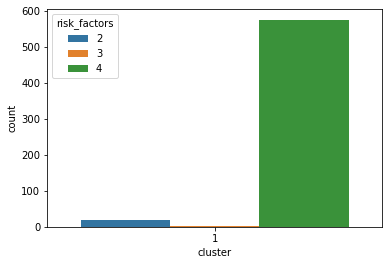

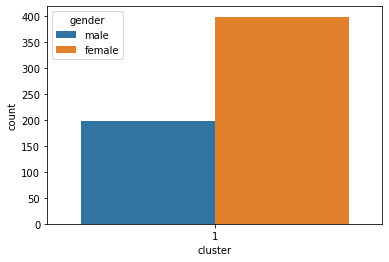

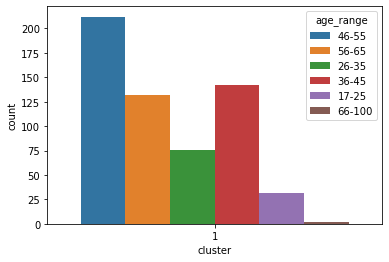

alt.Chart(...)

In [17]:
eda_cluster(df_obesity, 1)

### Cluster 2

In [18]:
def calc_obesity_kmodes_2(age, bmi, cc, rcc, ict, risk):
    
    if risk>=3: return 2
    
    if risk==2:        
        if age>=35 and (cc==1 or rcc==2): return 2  
        else: return 1
        
    # Si 1 riesgo y es acumulación de grasa abdominal, riesgo 1. Sino riesgo 0
    if risk==1: 
        if age>=35 and (cc==1 or rcc==2): return 1
        else: return 0
        

EDA cluster 2
**************************
                                                                                       cluster
age_range obesity_bmi_txt obesity_cc_txt obesity_rcc_txt obesity_ict_txt risk_factors         
17-25     0-Bajo Peso     0-Bajo         1-Medio         1-Normal        1                   5
                                         2-Alto          1-Normal        1                   1
          1-Normal        0-Bajo         1-Medio         1-Normal        1                  22
                                         2-Alto          1-Normal        1                   2
                          1-Alto         0-Bajo          1-Normal        1                  22
          2-Sobrepeso     0-Bajo         0-Bajo          0-Delgado       1                   1
                                                         1-Normal        1                  78
                                                         2-Sobrepeso     2                  19
         

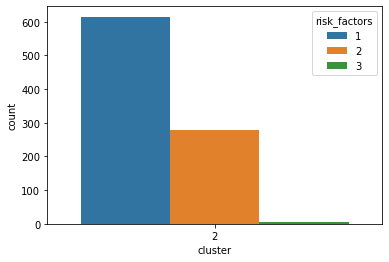

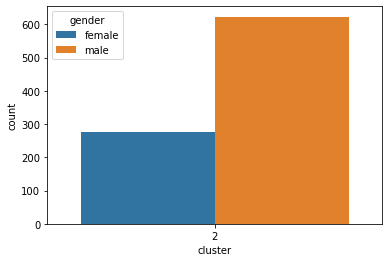

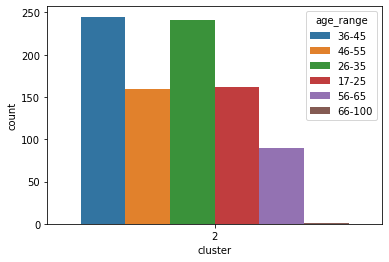

alt.Chart(...)

In [19]:
eda_cluster(df_obesity, 2)

### Cluster 3

In [20]:
def calc_obesity_kmodes_3(age, bmi, cc, rcc, ict, risk):
      
    if risk>=3: return 2
    
    if risk==2:
        if age>=35 and (cc==1 or rcc==2): return 2  
        else: return 1

        
        

EDA cluster 3
**************************
                                                                                       cluster
age_range obesity_bmi_txt obesity_cc_txt obesity_rcc_txt obesity_ict_txt risk_factors         
17-25     0-Bajo Peso     0-Bajo         2-Alto          2-Sobrepeso     2                   1
          1-Normal        0-Bajo         2-Alto          2-Sobrepeso     2                   3
                          1-Alto         0-Bajo          2-Sobrepeso     2                  12
                                         1-Medio         2-Sobrepeso     3                  24
                                         2-Alto          1-Normal        2                   2
                                                         2-Sobrepeso     3                  13
                                                         3-Obesidad      3                   1
          2-Sobrepeso     1-Alto         2-Alto          2-Sobrepeso     4                   4
26-35    

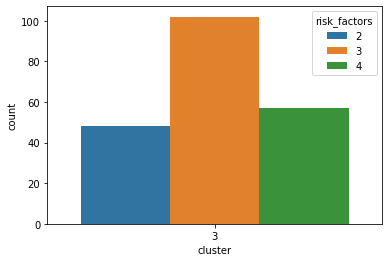

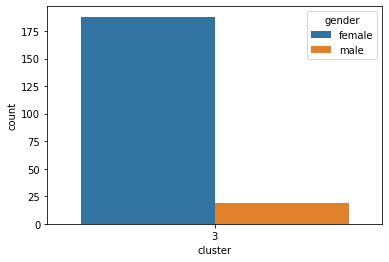

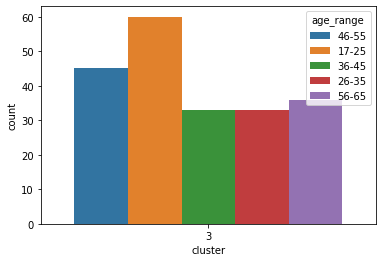

alt.Chart(...)

In [21]:
eda_cluster(df_obesity, 3)

### Cluster 4

In [22]:
def calc_obesity_kmodes_4(age, bmi, cc, rcc, ict, risk):
    
    return 2
        
        

EDA cluster 4
**************************
                                                                                       cluster
age_range obesity_bmi_txt obesity_cc_txt obesity_rcc_txt obesity_ict_txt risk_factors         
17-25     2-Sobrepeso     1-Alto         0-Bajo          2-Sobrepeso     3                  36
          3-Obesidad      0-Bajo         0-Bajo          2-Sobrepeso     2                   4
                          1-Alto         0-Bajo          2-Sobrepeso     3                  21
                                                         3-Obesidad      3                   9
26-35     2-Sobrepeso     1-Alto         0-Bajo          2-Sobrepeso     3                  54
          3-Obesidad      0-Bajo         0-Bajo          2-Sobrepeso     2                   8
                          1-Alto         0-Bajo          1-Normal        2                   1
                                                         2-Sobrepeso     3                  65
         

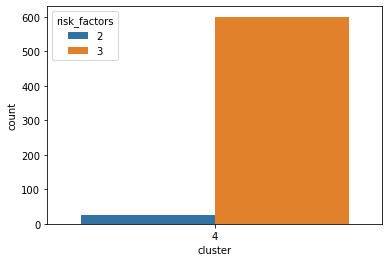

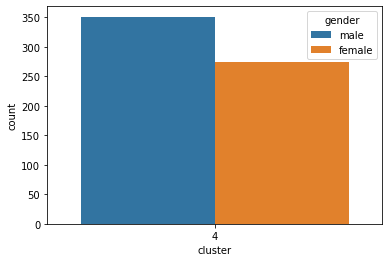

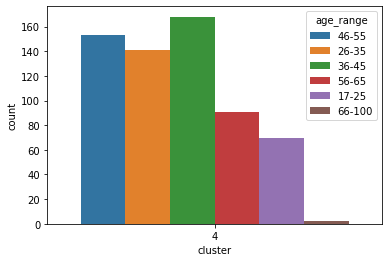

alt.Chart(...)

In [23]:
eda_cluster(df_obesity, 4)

### Cluster 5

In [24]:
def calc_obesity_kmodes_5(age, bmi, cc, rcc, ict, risk):

    return 0

EDA cluster 5
**************************
                                                                                       cluster
age_range obesity_bmi_txt obesity_cc_txt obesity_rcc_txt obesity_ict_txt risk_factors         
17-25     0-Bajo Peso     0-Bajo         0-Bajo          1-Normal        0                  17
          1-Normal        0-Bajo         0-Bajo          1-Normal        0                 541
26-35     0-Bajo Peso     0-Bajo         0-Bajo          1-Normal        0                   4
          1-Normal        0-Bajo         0-Bajo          1-Normal        0                 446
36-45     0-Bajo Peso     0-Bajo         0-Bajo          1-Normal        0                   4
          1-Normal        0-Bajo         0-Bajo          1-Normal        0                 349
46-55     1-Normal        0-Bajo         0-Bajo          1-Normal        0                 221
56-65     0-Bajo Peso     0-Bajo         0-Bajo          1-Normal        0                   3
         

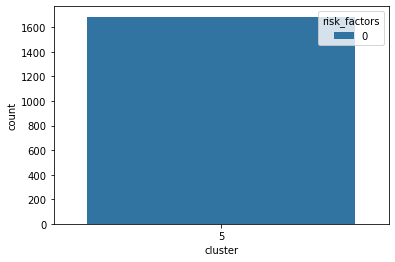

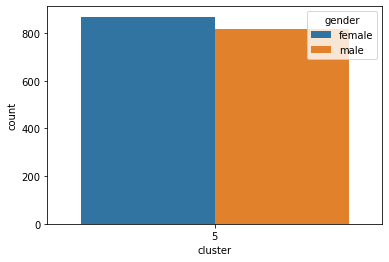

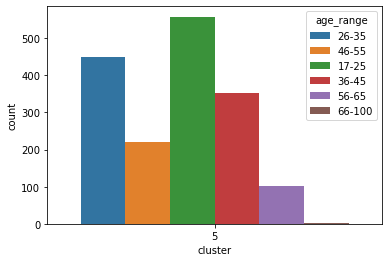

alt.Chart(...)

In [25]:
eda_cluster(df_obesity, 5)

### Cálculo de la variable objetivo

Calculamos el riesgo de sufrir sobrepeso/obesidad y de padecer ENT. 3 Valores:

- **0:** Riesgo nulo o bajo
- **1:** Riesgo moderado
- **2:** Riesgo alto

In [26]:
def calc_obesity(age, bmi, cc, rcc, ict, risk, cluster):
    if cluster==0: return calc_obesity_kmodes_0(age, bmi, cc, rcc, ict, risk)
    if cluster==1: return calc_obesity_kmodes_1(age, bmi, cc, rcc, ict, risk)
    if cluster==2: return calc_obesity_kmodes_2(age, bmi, cc, rcc, ict, risk)
    if cluster==3: return calc_obesity_kmodes_3(age, bmi, cc, rcc, ict, risk)
    if cluster==4: return calc_obesity_kmodes_4(age, bmi, cc, rcc, ict, risk)
    if cluster==5: return calc_obesity_kmodes_5(age, bmi, cc, rcc, ict, risk)

    

In [27]:
df_obesity['obesity'] = df_obesity.apply(lambda  row: calc_obesity(row['age'],
                                                                   row['obesity_bmi'],
                                                                   row['obesity_cc'], 
                                                                   row['obesity_rcc'],
                                                                   row['obesity_ict'],
                                                                   row['risk_factors'],
                                                                   row['cluster']), 
                                            axis=1)
                                         
                                         
df_obesity

age age_range  gender    height   weight  waist_circum_preferred  \
1     47.0     46-55    male  187.1980  156.630                138.5062   
2     50.0     46-55    male  180.5940   98.064                 98.3996   
3     28.0     26-35    male  182.7022   89.211                 97.0026   
4     52.0     46-55    male  185.9026  113.273                105.9942   
5     50.0     46-55    male  183.1086  108.279                104.0892   
...    ...       ...     ...       ...      ...                     ...   
4460  35.0     26-35  female  152.8064   49.259                 61.5950   
4461  40.0     36-45  female  168.6052   67.646                 73.8124   
4462  23.0     17-25  female  168.5036   73.775                 78.0034   
4463  24.0     17-25    male  170.5102   65.149                 75.7936   
4464  22.0     17-25  female  170.4086   61.290                 68.8086   

      hip_circum  gender_bin        bmi       rcc  ...  obesity_cc  \
1       142.1892           1  44.696399  0.974098  ...           1   
2       109.9058           1  30.067891  0.895309  ...           1   
3       107.0102           1  26.725809  0.906480  ...           1   
4       111.0996           1  32.775964  0.954047  ...           1   
5       112.3950           1  32.294365  0.926102  ...           1   
...          ...         ...        ...       ...  ...         ...   
4460     93.0910           0  21.096116  0.661664  ...           0   
4461    100.4062           0  23.795794  0.735138  ...           0   
4462    109.7026           0  25.983093  0.711044  ...           0   
4463     97.7900           1  22.408203  0.775065  ...           0   
4464    101.6000           0  21.106033  0.677250  ...           0   

      obesity_cc_txt obesity_rcc  obesity_rcc_txt obesity_ict  \
1             1-Alto           1          1-Medio           3   
2             1-Alto           0           0-Bajo           2   
3             1-Alto           0           0-Bajo           2   
4             1-Alto           1          1-Medio           2   
5             1-Alto           0           0-Bajo           2   
...              ...         ...              ...         ...   
4460          0-Bajo           0           0-Bajo           0   
4461          0-Bajo           0           0-Bajo           1   
4462          0-Bajo           0           0-Bajo           1   
4463          0-Bajo           0           0-Bajo           1   
4464          0-Bajo           0           0-Bajo           0   

      obesity_ict_txt risk_factors  cluster_kmeans cluster  obesity  
1          3-Obesidad            4               5       1        2  
2         2-Sobrepeso            3               1       4        2  
3         2-Sobrepeso            3               1       4        2  
4         2-Sobrepeso            4               1       1        2  
5         2-Sobrepeso            3               1       4        2  
...               ...          ...             ...     ...      ...  
4460        0-Delgado            0               2       0        0  
4461         1-Normal            0               2       5        0  
4462         1-Normal            1               0       2        0  
4463         1-Normal            0               0       5        0  
4464        0-Delgado            0               2       0        0  

[4430 rows x 23 columns]

In [28]:
df_obesity['obesity'].value_counts()

0    2660
2    1441
1     329
Name: obesity, dtype: int64

In [29]:
# Guardamos el resultado en un archivo parquet para el entrenamiento del modelo
    
df_obesity.to_parquet(f"{BASE_DIR}/data/out/obesity_labeled.parquet", 
                compression='GZIP',
                engine='pyarrow')

### Estudio de la Obesidad calculada

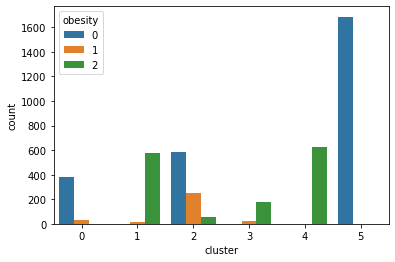

In [30]:

sns.countplot(x='cluster', hue='obesity', data=df_obesity)
plt.show()

In [31]:
# Estudio Obesidad y riesgo de ENT (calculado)

x = 'count(*):Q'
y = 'age_range:O'
detail = 'obesity:N'

title='Cantidad de Individuos según su rango de edad y su grado de riesgo'
title_f='Sólo Mujeres'
title_m='Sólo Hombres'

title_x = 'Total individuos'
title_y = 'Rangos de Edad'

char_total = ccf.char_bars(df_obesity, x, y, detail, title, title_x, title_y)

char_total



alt.LayerChart(...)

In [32]:
# Estudio Obesidad y riesgo de ENT (calculado)

x = 'count(*):Q'
y = 'age_range:O'
detail = 'risk_factors:N'

title='Cantidad de Individuos según su rango de edad y cantidad de factores de riesgo'
title_f='Sólo Mujeres'
title_m='Sólo Hombres'

title_x = 'Total individuos'
title_y = 'Rangos de Edad'

char_total = ccf.char_bars(df_obesity, x, y, detail, title, title_x, title_y)

char_total

alt.LayerChart(...)

In [33]:
# Estudio Obesidad y riesgo de ENT (calculado)

x = 'count(*):Q'
y = 'age_range:O'
detail = 'cluster:N'

title='Cantidad de Individuos según su rango de edad y grado de Obesidad y riesgo de ENT (KModes)'

title_x = 'Total individuos'
title_y = 'Rangos de Edad'

char_total = ccf.char_bars(df_obesity, x, y, detail, title, title_x, title_y)

char_total

alt.LayerChart(...)